Fazendo baselines zero-shot/few-shot com o BERTimbau para ver se o GANBERT tem o efeito desejado

In [1]:
#pra conseguir algum erro util da porra do torch
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import pipeline, AutoTokenizer, AutoModel,AutoConfig,get_constant_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score
from tqdm import tqdm

import torch
from torch import nn
import time
import random
import datetime
import math

#TODO: ver de fazer o pull request pra ver se o cara arruma essa porcaria de função, ao invés dessa gambiarra
from skmultilearn.skmultilearn.model_selection.iterative_stratification import iterative_train_test_split, IterativeStratification
from sklearn.utils.class_weight import compute_class_weight


tqdm.pandas()

In [3]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)
  device = 0

In [4]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [5]:
remove_neutral_instances= True

In [6]:
max_length = 128

unlabeled_ratio = 50
num_hidden_layers_g = 3
num_hidden_layers_d = 1

noise_size = 100
out_dropout_rate = 0.3

apply_balance = True

learning_rate_discriminator = 0.001
learning_rate_generator = 0.001
epsilon = 1e-8
num_train_epochs = 30
multi_gpu = True

apply_scheduler = True
warmup_proportion = 0.1

print_each_n_step = 100

batch_size = 64

model_path = "neuralmind/bert-base-portuguese-cased"




# Dados

In [7]:
df = pd.read_csv("data/segredos_sentenças_multitask_clean.csv",index_col=0)


In [8]:
df = df.drop(["Postagem com possível perfil depressivo","Alteração na eficiência",
         "Alteração da funcionalidade","*",'Agitação/inquietação','Sintoma obsessivo e compulsivo','Déficit de atenção/Memória',
              'Perda/Diminuição do prazer/ Perda/Diminuição da libido'],axis=1)

In [9]:
symptom_num = df.iloc[:,1:].shape[1]
target_names = list(df.iloc[:,1:].columns)

In [10]:
if remove_neutral_instances == True:
    df = df.reset_index(drop=True)
    df = df[df.iloc[:,1:].sum(axis=1) != 0]
    

In [11]:
df = df.reset_index(drop=True)

In [12]:
#train_df,_,test_df, _ = iterative_train_test_split(df,df.iloc[:,1:],test_size=0.5)

In [13]:
strat = IterativeStratification(n_splits=2).split(df,df.iloc[:,1:])
for train_idx, test_idx in strat:

    train_df = df.loc[train_idx]
    test_df  = df.loc[test_idx]
    break

In [14]:
#label_to_idx = {sintoma:i for i,sintoma in enumerate(label_list)}
#idx_to_label = {i:sintoma for i,sintoma in enumerate(label_list)}

In [15]:
unlabeled = pd.read_csv("data/reddit_sentences_depress.csv")

In [16]:
#unlabeled = pd.read_csv("data/lrec2020.csv",sep=";")
#if unlabeled_ratio:
#    size = train_df.shape[0] * unlabeled_ratio
#    unlabeled = unlabeled.sample(size,random_state=seed_val)

In [17]:
#unlabeled.rename(columns = {'Text':'text'}, inplace = True)

In [18]:
#

# Carregando modelo

In [19]:
transformer = AutoModel.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# dataloader

In [20]:
#dataloaders



def get_dataloader(df,label_masks,tokenizer,batch_size,do_shuffle,balance_label_examples):
    examples = []
    input_ids = []
    attention_masks = []
    label_mask_array = []
    num_labeled_examples = 0
    for label_mask in label_masks:
        if label_mask:
            num_labeled_examples += 1
    label_mask_rate = num_labeled_examples/df.shape[0]
    balance = int(1/label_mask_rate)
    balance = int(math.log(balance,2))
    
    for index,row in df.iterrows():
        if label_mask_rate == 1 or not balance_label_examples:
            examples.append(row)
            label_mask_array.append(label_masks[index])
        else:
            #oversampling
            if label_masks[index]:
                if balance < 1:
                    balance = 1
                for b in range(0,int(balance)):
                    examples.append(row)
                    label_mask_array.append(label_masks[index])
            else:
                examples.append(row)
                label_mask_array.append(label_masks[index])

    
    examples = pd.DataFrame(examples)
    
    for text in examples.text:
        encoded = tokenizer.encode_plus(text,return_attention_mask=True,add_special_tokens=True,max_length = max_length,
    padding="max_length",truncation=True)
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    
    label_mask_array = torch.tensor(label_mask_array)
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(examples.iloc[:,1:].to_numpy(),dtype=torch.float32)
    
    dataset = torch.utils.data.TensorDataset(input_ids,attention_masks,labels,label_mask_array)
    
    if do_shuffle:
        sampler = torch.utils.data.RandomSampler
    else:
        sampler = torch.utils.data.SequentialSampler
    return torch.utils.data.DataLoader(dataset,sampler = sampler(dataset),batch_size=batch_size)
    
       

In [21]:
train_examples = pd.concat([train_df,unlabeled])

In [22]:
train_examples = train_examples.iloc[:,:-(len(unlabeled.columns))+1].fillna(0)

train_examples = train_examples.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [23]:
train_label_masks = np.ones(train_df.shape[0],dtype=bool)

tmp_masks = np.zeros(unlabeled.shape[0],dtype=bool)
train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = get_dataloader(train_examples,train_label_masks,tokenizer,do_shuffle=True,batch_size=batch_size,
                                       balance_label_examples = apply_balance)


test_label_masks = np.ones(test_df.shape[0],dtype=bool)
test_dataloader = get_dataloader(test_df, test_label_masks,
                                       tokenizer,do_shuffle=False,batch_size=batch_size,
                                       balance_label_examples = apply_balance)

/tmp/ipykernel_241405/2298553614.py:44: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  label_mask_array = torch.tensor(label_mask_array)


# arquitetura

In [24]:
#------------------------------
#   The Generator as in 
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
        super(Generator, self).__init__()
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.2):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.sigmoid = torch.sigmoid

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.sigmoid(logits)
        return last_rep, logits, probs

In [25]:
# The config file is required to get the dimension of the vector produced by 
# the underlying transformer
config = AutoConfig.from_pretrained(model_path)
hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=symptom_num, dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():    
  generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)


In [26]:
#para referência https://link.springer.com/chapter/10.1007/978-3-642-38679-4_37
#e também https://www.kaggle.com/code/rejpalcz/best-loss-function-for-f1-score-metric

#por algum motivo foi pior do que otimizar por BCE...
#ainda é bom deixar guardado aqui, vai que é útil um dia!
def f1_differentiable_loss(sigmoid_vals,labels):
    #em caso de precisão ou recall igual a 0
    eps=1e-10
    #estamos tratando das probabilidades.
    #por exemplo, se labels é [0,1] e temos a prob [0.3,0.9]
    #temos um true positive rate de 0 + 0.9
    # um true negative rate de 0.7 + 0
    # um false positive rate de 0.3
    # e por fim um false negative rate de 0.1
    tp = torch.sum(labels*sigmoid_vals)
    tn = torch.sum((1-labels)*(1-sigmoid_vals))
    fp = torch.sum((1-labels)*sigmoid_vals)
    fn = torch.sum(labels * (1-sigmoid_vals))
    
    p = tp / (tp + fp) + eps
    r = tp / (tp + fn) +eps
    
    f1 = 2*p*r/ (p+r) + eps
    #queremos minimizar a perda de f1, portanto 1-f1
    return 1-f1

In [27]:
#não funciona por causa da versão do CUDA, eu acho. tentei o nightly do 11.6, mas o site especifica 11.7
#depois tenho que ver de atualizar, o ganho de performance aparentemente é muito bom
#transformer = transformer.compile()

In [28]:
def focal_binary_cross_entropy(p,targets,gamma=3,alpha=0.9):
    bce = torch.nn.functional.binary_cross_entropy(p,targets,reduction='none')
    p = torch.where(targets == 1,p,1-p)
    alpha = targets * alpha + (1-targets) * (1 - alpha)
    return (alpha * (1 - p) ** gamma).mean()

## Finetuning

In [29]:

start_supervised_on_epoch_i = 19

training_stats = []

total_t0 = time.time()

total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
g_vars = [v for v in generator.parameters()]

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
  scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

#lembrando que a função sigmoid é um "s" com o "meio" em x=0 y=0.5
threshold = 0.5 
#loss_func = torch.nn.BCELoss()
#loss_func = f1_differentiable_loss
loss_func = focal_binary_cross_entropy
sigmoid = torch.sigmoid
best_f1 = 0
best_epoch = 0
best_report = {}
best_avg_prec = 0

for epoch_i in range(0,num_train_epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')
    t0 = time.time()
    
    tr_g_loss = 0
    tr_d_loss = 0
    tr_d_supervised_loss = 0
    
    transformer.train() 
    generator.train()
    discriminator.train()
    
    for step, batch in enumerate(train_dataloader):
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_label_mask = batch[3].to(device)
        
        cur_batch_size = b_input_ids.shape[0]
        
        transformer_outputs = transformer(b_input_ids,attention_mask=b_input_mask)
        hidden_states = transformer_outputs[-1]
        
        
        #generator stuff
        noise = torch.zeros(cur_batch_size,noise_size,device=device).uniform_(0,1)
        gen_rep = generator(noise)
        
        #discriminator stuff
        discriminator_input = torch.cat([hidden_states,gen_rep],dim=0)
        features,logits,probs = discriminator(discriminator_input)
        
        
        #separating real and fake data outputs
        features_list = torch.split(features, cur_batch_size)
        D_real_features = features_list[0]
        D_fake_features = features_list[1]
      
        logits_list = torch.split(logits, cur_batch_size)
        D_real_logits = logits_list[0]
        D_fake_logits = logits_list[1]
        
        probs_list = torch.split(probs, cur_batch_size)
        D_real_probs = probs_list[0]
        D_fake_probs = probs_list[1]
        
        
        
        #generator loss
        g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
        g_loss = g_loss_d + g_feat_reg
        g_loss = 2 * g_loss
        
        #discriminator loss
        
        logits = D_real_logits[:,0:-1]
        
        #labeled_probs = torch.masked_select(D_real_probs,b_label_mask)
        labeled_probs = D_real_probs[b_label_mask][:,0:-1]
        filtered_labels = b_labels[b_label_mask]
        if sum(b_label_mask) == 0 or epoch_i < start_supervised_on_epoch_i:
            D_L_Supervised = 0
        else:
            D_L_Supervised = loss_func(labeled_probs,filtered_labels) *20
        
        
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U
        
        if D_L_Supervised != 0:
            tr_d_supervised_loss += D_L_Supervised.detach().item()
                
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        
        g_loss.backward(retain_graph=True)
        d_loss.backward()
        
        gen_optimizer.step()
        dis_optimizer.step()
        
        tr_g_loss += g_loss.detach().item()
        tr_d_loss += d_loss.detach().item()
        
        if apply_scheduler:
            scheduler_d.step()
            scheduler_g.step()
    avg_train_loss_g = tr_g_loss / len(train_dataloader)
    avg_train_loss_d = tr_d_loss / len(train_dataloader)
    avg_train_loss_supervised_d = tr_d_supervised_loss/ len(train_dataloader)

    
        
        
        
            
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
    print(" Average training loss supervised: {0:.3f}".format(avg_train_loss_supervised_d))
    print(" Training epoch took: {:}".format(training_time))
    
    
    
    
    
    
    
    
    
    
    print("")
    print("Running Test...")
    
    t0 = time.time()
    
    transformer.eval()
    discriminator.eval()
    generator.eval()
    
    total_test_loss = 0
    nb_test_steps = 0
    
    all_preds = []
    all_labels_ids = []
    all_probs = []
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():
            transformer_outputs = transformer(b_input_ids,attention_mask=b_input_mask)
            hidden_states = transformer_outputs[-1]
            
            _,_,probs = discriminator(hidden_states)
            filtered_probs = probs[:,0:-1]
            
            total_test_loss += loss_func(filtered_probs,b_labels).detach().item()
            preds = filtered_probs > threshold
            probs = filtered_probs
        all_probs += probs.detach().cpu()
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()
        
    all_probs = torch.stack(all_probs).numpy()
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
        
    cur_avg_prec = average_precision_score(all_labels_ids,all_probs)
    if best_avg_prec < cur_avg_prec:
        best_avg_prec = cur_avg_prec
    print("Average Precision: ",best_avg_prec)

    
    cur_report = classification_report(all_labels_ids,all_preds,target_names=target_names, zero_division=0,output_dict=True)
    if cur_report['macro avg']['f1-score'] >= best_f1:
        best_f1 = cur_report['macro avg']['f1-score']
        best_epoch = epoch_i
        best_report = cur_report
    
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss
    
    test_time = format_time(time.time() - t0)
    print("F1-score: ",cur_report['macro avg']['f1-score'])
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Training Supervised Loss': avg_train_loss_supervised_d,
            'F1-score':cur_report['macro avg']['f1-score'],
            'Training Time': training_time,
            'Test Time': test_time
        })


======== Epoch 1 / 30 ========
Training...

  Average training loss generetor: 1.030
  Average training loss discriminator: 1.175
 Average training loss supervised: 0.000
 Training epoch took: 0:00:23

Running Test...
Average Precision:  0.08797596294417304
F1-score:  0.04425190518338444
  Test Loss: 0.020
  Test took: 0:00:01

======== Epoch 2 / 30 ========
Training...

  Average training loss generetor: 0.836
  Average training loss discriminator: 1.153
 Average training loss supervised: 0.000
 Training epoch took: 0:00:23

Running Test...
Average Precision:  0.08797596294417304
F1-score:  0.058039263477878494
  Test Loss: 0.020
  Test took: 0:00:01

======== Epoch 3 / 30 ========
Training...

  Average training loss generetor: 0.829
  Average training loss discriminator: 1.136
 Average training loss supervised: 0.000
 Training epoch took: 0:00:23

Running Test...
Average Precision:  0.08797596294417304
F1-score:  0.042567363510930066
  Test Loss: 0.020
  Test took: 0:00:01

=======


  Average training loss generetor: 0.846
  Average training loss discriminator: 1.457
 Average training loss supervised: 0.343
 Training epoch took: 0:00:23

Running Test...
Average Precision:  0.08797596294417304
F1-score:  0.07029943179030214
  Test Loss: 0.017
  Test took: 0:00:01

======== Epoch 27 / 30 ========
Training...

  Average training loss generetor: 0.843
  Average training loss discriminator: 1.461
 Average training loss supervised: 0.346
 Training epoch took: 0:00:23

Running Test...
Average Precision:  0.08797596294417304
F1-score:  0.07928449886192958
  Test Loss: 0.016
  Test took: 0:00:01

======== Epoch 28 / 30 ========
Training...

  Average training loss generetor: 0.840
  Average training loss discriminator: 1.461
 Average training loss supervised: 0.344
 Training epoch took: 0:00:23

Running Test...
Average Precision:  0.08797596294417304
F1-score:  0.0603922333955191
  Test Loss: 0.017
  Test took: 0:00:01

======== Epoch 29 / 30 ========
Training...

  Avera

In [30]:
best_fine_tuning_report = best_report
best_fine_tuning_epoch = best_epoch

In [31]:
best_avg_prec

0.08797596294417304

# fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(best_fine_tuning_report).iloc[:-1, :].T, annot=True)

<AxesSubplot:>

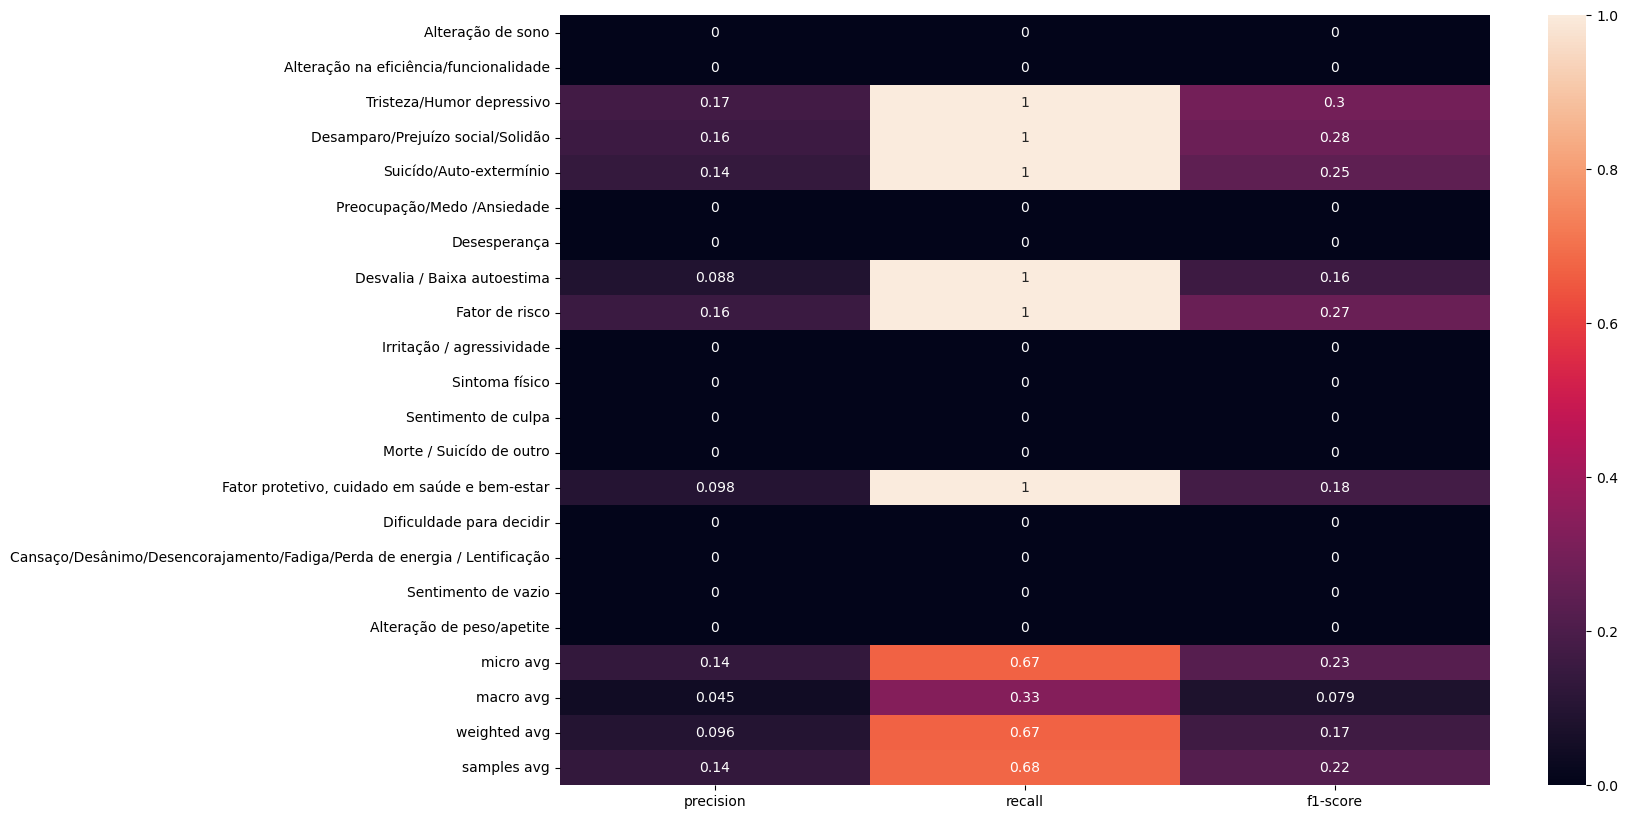

In [32]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(best_fine_tuning_report).iloc[:-1, :].T, annot=True)

In [33]:
best_fine_tuning_epoch

26

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

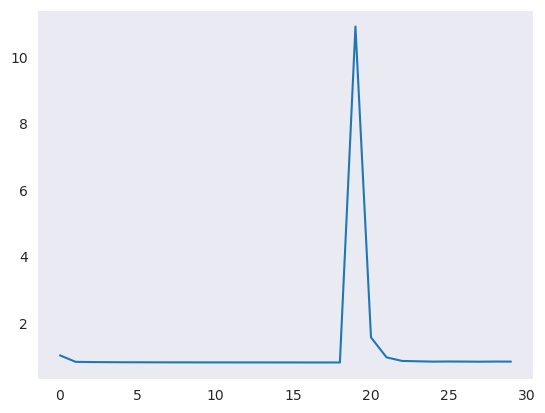

In [34]:
losses = pd.DataFrame(training_stats)[["Training Loss generator", "Training Loss discriminator","F1-score","Training Supervised Loss"]]

#overffiting com a acurácia aumentando? Tem algo estranho aqui...
sns.set_style("dark")
ax = sns.lineplot(data=losses)
ax.set(xlabel="Epoch",ylabel="Loss")
sns.despine()